# Análisis para Zuber

## Objetivo
Encontrar patrones entre las preferencias de los usuarios y el impacto de los factores externos

## Pasos a seguir:

* Importar los archivos
* Limpieza de datos
* Identificar los 10 principales barrios en términos de finalización del recorrido
* Hacer gráficos: empresas de taxis y número de viajes, los 10 barrios principales por número de finalizaciones
* Sacar conclusiones basadas en cada gráfico y explicar los resultados


In [115]:
# importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import levene

# Visualización general de los datos

In [116]:
# importar los datasets
cabs = pd.read_csv('moved_project_sql_result_01.csv')
neighborhoods = pd.read_csv('moved_project_sql_result_04.csv')
trips_to_airport = pd.read_csv('moved_project_sql_result_07.csv')

In [117]:
# información general de cabs
cabs.info()
print('\n', cabs.sample(5))
print('\n', 'Hay', cabs.duplicated().sum(), 'filas duplicadas')
print('\n', 'Hay', cabs['company_name'].nunique(), 'empresas de taxis')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB

                       company_name  trips_amount
33                Metro Jet Taxi A           146
45       3011 - 66308 JBL Cab Inc.            25
1        Taxi Affiliation Services         11422
42     1085 - 72312 N and W Cab Co            29
43  2809 - 95474 C & D Cab Co Inc.            29

 Hay 0 filas duplicadas

 Hay 64 empresas de taxis


In [118]:
# información general de neighborhoods
neighborhoods.info()
print('\n', neighborhoods.sample(5))
print('\n', 'Hay', neighborhoods.duplicated().sum(), 'filas duplicadas')
print('\n', 'Hay', neighborhoods['dropoff_location_name'].nunique(), 'barrios de Chicago en donde finalizaron los viajes')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB

    dropoff_location_name  average_trips
78             Gage Park       8.233333
5              Lake View    2420.966667
40              Bucktown      74.300000
28           Wicker Park     182.600000
73          Chicago Lawn      12.266667

 Hay 0 filas duplicadas

 Hay 94 barrios de Chicago en donde finalizaron los viajes


In [119]:
# información general de trips_to_airport
trips_to_airport.info()
print('\n', trips_to_airport.sample(5))
print('\n', 'Hay', trips_to_airport.duplicated().sum(), 'valores duplicados')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB

                  start_ts weather_conditions  duration_seconds
403   2017-11-11 14:00:00               Good            2400.0
1050  2017-11-11 16:00:00               Good            2280.0
852   2017-11-18 16:00:00                Bad            3120.0
204   2017-11-18 19:00:00               Good               0.0
932   2017-11-04 12:00:00               Good            3180.0

 Hay 197 valores duplicados


### Comentario
En los DataFrames de "cabs" y "neighborhoods" no se encuentran valores usentes ni valores duplicados y los tipos de datos se encuentran correctos. Los datos están listos para los posteriores análisis.

En el DataFrame de "trips_to_airport" no hay valores nulos, pero si hay valores duplicados y el tipo de dato de "start_ts" es incorrecto. Se deben de revisar los valores duplicados y cambiar el tipo de dato a ``Datetime``.

# Limpieza de datos

In [120]:
# conversión a datetime en trips_to_airport
trips_to_airport['start_ts'] = pd.to_datetime(trips_to_airport['start_ts'])

In [143]:
# revisión de valores duplicados en trips_to_airport
print(trips_to_airport[trips_to_airport.duplicated()])

# muestra con "2017-11-11 06:00:00"
print('\n', 'Muestra con fecha "2017-11-11 06:00:00":')
print(trips_to_airport.query('start_ts == "2017-11-11 06:00:00"'))

                start_ts weather_conditions  duration_seconds
62   2017-11-11 06:00:00               Good            1260.0
74   2017-11-11 08:00:00               Good            1380.0
76   2017-11-04 09:00:00               Good            1380.0
117  2017-11-11 07:00:00               Good            1380.0
119  2017-11-04 14:00:00               Good            3300.0
...                  ...                ...               ...
1054 2017-11-11 07:00:00               Good            1380.0
1058 2017-11-25 12:00:00               Good            1440.0
1062 2017-11-11 06:00:00               Good            1500.0
1065 2017-11-11 13:00:00               Good            2100.0
1066 2017-11-11 08:00:00               Good            1380.0

[197 rows x 3 columns]

 Muestra con fecha "2017-11-11 06:00:00":
                start_ts weather_conditions  duration_seconds
43   2017-11-11 06:00:00               Good            1260.0
62   2017-11-11 06:00:00               Good            1260.0
81 

C:\Users\ivann\AppData\Local\Temp\ipykernel_21976\1827902023.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  print(trips_to_airport.query('start_ts == "2017-11-11 06:00:00"'))


### Comentario
Se convirtió la columna "start_ts" al tipo de dato correcto. Revisando los valores duplicados me puedo percatar que probablemente se deban a que hubo varios viajes que se finalizaron en ese mismo día a la misma hora, sin embargo, sería importante reportarlo con el ``desarrollador`` para considerar agregar el campo del ``ID`` del viaje y validar si efectivamente son diferentes viajes o si son duplicados.

# Análisis exploratorio

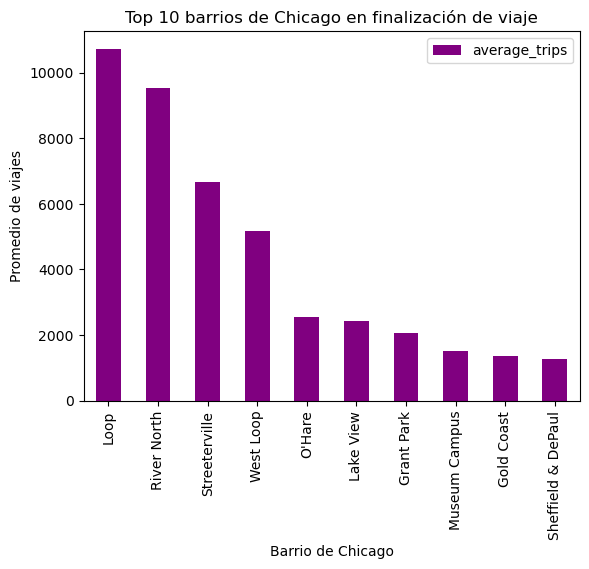

In [122]:
# top 10 barrios en finalización de recorrido
top_10_neighborhoods = neighborhoods.sort_values('average_trips', ascending=False).head(10)

# gráfico top 10 barrios
top_10_neighborhoods.plot(title='Top 10 barrios de Chicago en finalización de viaje' ,
                          kind='bar',
                          x='dropoff_location_name',
                          ylabel='Promedio de viajes',
                          xlabel='Barrio de Chicago',
                          color='purple')

plt.show()

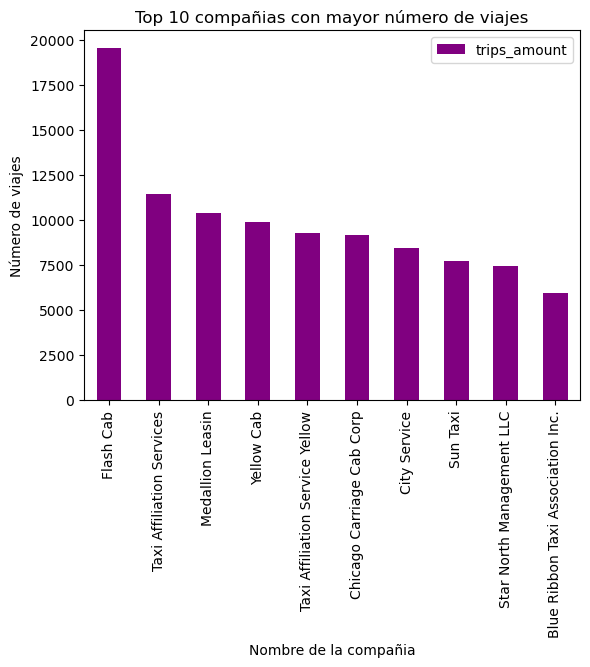

In [123]:
# top 10 empresas con mayor número de viajes
top_10_company = cabs.sort_values('trips_amount', ascending=False).head(10)

# gráfico top 10 compañias con mayor número de viajes
top_10_company.plot(title='Top 10 compañias con mayor número de viajes' ,
                          kind='bar',
                          x='company_name',
                          ylabel='Número de viajes',
                          xlabel='Nombre de la compañia',
                          color='purple')

plt.show()

### Comentario
En cuanto a los destinos de los viajes, el lugar con mayor número de finalizaciones es el barrio "Loop" seguido por "River North", esto puede deberse a que son zonas de alta concentración laboral, sitios turísticos o son puntos centrales de transporte.

Por otro lado, la empresa que realiza mayor número de viajes es "Flash Cab", en el gráfico se puede apreciar una notable diferencia con respecto a sus competidores. La preferencia por esta compañía puede deberse a la calidad de servicio que ofrece, el tipo de autos que usa como transporte, el precio de los viajes o la velocidad en la tasa de respuesta de aceptación del viaje por parte de los choferes. 

# Prueba de hipótesis

Para la prueba de hipótesis se empleará el DataFrame "trips_to_airport" que contiene los viajes realizados desde el barrio "Loop" hasta el "Aeropuerto Internacional O'Hare".

* H₀ "La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare NO cambia los sábados lluviosos"
* H₁ "La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos"

Para la prueba de hipótesis se plantea usar una prueba t de dos colas ya que se busca saber si el estado del clima es un factor relacionado con la duración promedio de los viajes. Se establece un nivel de significancia de .05 de tal forma que se mantiene un grado de confiabilidad de los resultado en un 95%.

In [ ]:
# valores en weather_conditions
print(trips_to_airport['weather_conditions'].unique())

['Good' 'Bad']


In [ ]:
# función para realizar la prueba de la hipótesis con prueba t
def prueba_hipótesis(df, columna, condicion_1, condicion_2, alpha=.05):
    
    '''
    Realiza la prueba t tomando en cuenta la prueba levene para definir si las varianzas son iguales o diferentes
    '''
    
    # estblecer grupos
    grupo_1 = df[df[columna]==condicion_1]['duration_seconds']
    grupo_2 = df[df[columna]==condicion_2]['duration_seconds']
    
    # prueba de levene
    stat_levene, p_levene = levene(grupo_1, grupo_2)
    
    if p_levene < alpha:
        equal_var = False
    else:
        equal_var = True
    
    # prueba t
    t_stat, p_value = st.ttest_ind(grupo_1, grupo_2, equal_var=equal_var)
    
    print(f'¿Es significativa la diferencia en el tiempo de traslado entre las condiciones de {columna} para {condicion_1} y {condicion_2}?')
    print(f'La media de tiempo de traslado para {condicion_1} es {grupo_1.mean()}')
    print(f'La media de tiempo de traslado para {condicion_2} es {grupo_2.mean()}')
    
    # resultado levene
    if p_levene < alpha:
        print('Las varianzas son diferenes')
    else:
        print('Las varianzas son iguales')
    
    # resultados prueba t 
    if p_value < alpha:
        print('Se rechaza la hipótesis nula')
    else:
        print('No se rechaza la hipótesis nula')

In [126]:
prueba_hipótesis(trips_to_airport, 'weather_conditions', 'Good', 'Bad')

¿Es significativa la diferencia en el tiempo de traslado entre las condiciones de weather_conditions para Good y Bad?
La media de tiempo de traslado para Good es 1999.6756756756756
La media de tiempo de traslado para Bad es 2427.2055555555557
Las varianzas son iguales
Se rechaza la hipótesis nula


## Conclusión
Una vez finalizados los análisis se puede concluir que los barrios "Loop" y "River North" son los destinos más frecuentes en los viajes de los usuarios, se recomienda estudiar la zona para determinar el motivo de esto y considerar en futuros análisis si hay alguna relación con la hora del día o el día de la semana (p. ej. si es una zona de alta concentración laboral puede haber un aumento en el número de viajes realizados de lunes-viernes en algunos horarios particulares).

La empresa "Flash Cab" domina en el mayor número de viajes realizados, se recomienda realizar una encuesta de satisfacción a un grupo de usuarios para poder validar cuales son los factores que la mantienen como la lider en viajes.

Finalmente, los resultados de la prueba de hipótesis muestran que la duración de los viajes realizados los sábados si se ve influenciada por el factor "lluvia".